# Initialization and Activation Units: A Numerical Stability's Perspective


This assignment will use the following external packages:
pytorch == 1.6.0
graphviz == 2.38

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn

## (a) Floating-point representations of real numbers

Mathematically, our models are typically represented by real numbers with infinite precision. However, when programming, it is inevtiable that we can only use representations with limited precision. For example, our data are usually stored as floating-point numbers. This short question requires you to recall such basic concepts in computer science. Please read the following codes and answer the followinng questions in your comments.

1. Why ``print(a)`` shows ``0.0``? Why ``print(b)`` shows ``inf``?

2. Why ``print(c)`` and ``print(d)`` can give you the correct values, but ``print(c + d - d)``, ``print(c * c)`` or ``print(d * d)`` cannot?


In [4]:

a = 1e-10000
print(a)

b = 1e+10000
print(b)



0.0
inf


In [6]:
c = 1e-250
print(c)

d = 1e+250
print(d)

print(c + d - d)
print(c * c)
print(d * d)

1e-250
1e+250
0.0
0.0
inf


### start (a)

Your answers here

### end (a)

### start sol-(a)

1. ...

2. ...

### end sol-(a)

## (c) Gradient vanishing and exploding - Theory 2

This part aims to give students some intuitions on on numerical issues we talked about in previous parts. Also, it helps you verify you answers in previous parts because you can try different experiments to examine the formula you get.


Without loss of generality, we use normal distribution with zero mean for all random varibales. Also, for all internal layers ($l \neq 0, l \neq L$), we assume that $ n^{(l-1)} =  n^{(l)} = N$, $ F_{ \mathbf{W}^{(l-1)} } = F_{ \mathbf{W}^{(l)} }$ (their weights have the same distribution), and  $ F_{ (\sigma')^{(l-1)} } = F_{ (\sigma')^{(l)} }$ (those diagnoal matrices have the same distribution). In the code, the last assumption is acchieved by make $ z_{i}^{(l)}$ has the same distribution. For boundary conditions, we assume $n^{(0)} = n^{(L)} = 1$, you can imagine that we are trying to fit a $1$-D function.

In [8]:
def sigma(x, activation="tanh"):
    # tsanh
    if (activation == "tanh"):
        result = np.tanh(x)
    # sigmoid
    elif (activation == "sigmoid"):
        sigmoid = 1 / (1 + np.exp(-x))
        result = sigmoid
    # relu
    elif (activation == "relu"):
        result = np.maximum(x, 0)
    else:
        raise NotImplementedError
    return(result)

def sigma_prime(x, activation="tanh"):
    # tsanh
    if (activation == "tanh"):
        result = 1 - np.tanh(x) ** 2
    # sigmoid
    elif (activation == "sigmoid"):
        sigmoid = 1 / (1 + np.exp(-x))
        result = sigmoid * (1 - sigmoid)
    # relu
    elif (activation == "relu"):
        result = (x > 0).astype("float")
    else:
        raise NotImplementedError
    return(result)


In [10]:
# sample our random matrices from distributions defined by gamma_z and gamma_w
def sample_random_matrices(gamma_z, gamma_w, n_in, n_out, activation="tanh"):
    z = gamma_z * np.random.randn(n_out)
    a = sigma(z, activation=activation)
    da_dz = sigma_prime(z, activation=activation)
    diag = np.diag(da_dz)

    W = gamma_w * np.random.randn(n_out, n_in)

    # print("sample_random_matrices: (n_out, n_in)", (n_out, n_in))
    # print("sample_random_matrices: diag", diag.shape)
    # print("sample_random_matrices: W", W.shape)

    return (z, a, da_dz, diag, W)


In [12]:
### play with parameters here 
L = 10
N = 10
gamma_z = 1.0
gamma_w = 10.0
###
n_0 = 1
n_L = 1


z, a, da_dz, diag, W = sample_random_matrices(gamma_z, gamma_w, N, N)

print(z)
print(a)
print(da_dz)

[ 0.38937588 -0.08886823 -0.1456216  -0.87759684  0.15447503  0.12351874
 -0.8518587  -0.61644734 -1.3400962  -1.77057338]
[ 0.37082205 -0.08863502 -0.14460092 -0.70521336  0.15325792  0.12289438
 -0.69203925 -0.54864962 -0.87169535 -0.94367223]
[0.86249101 0.99214383 0.97909057 0.50267412 0.97651201 0.98489697
 0.52108167 0.6989836  0.24014721 0.10948272]


In [14]:
# calculate the gradient of loss w.r.t. the the l-th layer's weight
def grad_wrt_weight(gamma_z,gamma_w, L, l, N, activation="tanh"):
    assert (l > 1), ValueError("Don't use the firt layer!")
    assert (l < L), ValueError("Don't use the last layer!")

    # for the last layer and the final loss
    delta = np.random.randn(N)

    for i in range(L-1, l, -1):
        # think about why we want to sample a new couple of matrices for each iteration
        z, a, da_dz, diag, W = sample_random_matrices(gamma_z, gamma_w, n_in=N, n_out=N, activation=activation)
        delta = W.T @ diag @ delta

    z, a, da_dz, diag, W = sample_random_matrices(gamma_z, gamma_w, n_in=N, n_out=N, activation=activation)
    delta = diag @ delta
    # print(delta.shape)

    grad = np.outer(delta, a.T)
    # print(grad.shape)

    return(grad)

In [16]:
### try change parameters here 
L = 10
l = 2
N = 1024
gamma_z = 100
gamma_w = 100
###
n_0 = 1
n_L = 1


grad_wrt_weight(gamma_z=gamma_z, gamma_w=gamma_w, L=L, l=l, N=N, activation="sigmoid")

# TODO
# visuallize / interactive plot

array([[ 1.00845679e-159,  1.31844347e-084,  1.44075923e-082, ...,
         1.74534468e-093,  1.02724236e-088,  6.70836048e-074],
       [-4.30625706e-085, -5.62994525e-010, -6.15225132e-008, ...,
        -7.45287547e-019, -4.38647419e-014, -2.86456743e+001],
       [ 5.04338789e-083,  6.59366063e-008,  7.20537333e-006, ...,
         8.72863402e-017,  5.13733632e-012,  3.35491460e+003],
       ...,
       [-2.56907142e-093, -3.35877102e-018, -3.67037379e-016, ...,
        -4.44631361e-027, -2.61692819e-022, -1.70897330e-007],
       [ 1.97053473e-088,  2.57625183e-013,  2.81525805e-011, ...,
         3.41042110e-022,  2.00724193e-017,  1.31082040e-002],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000]])

## (d) Graident vanishing and exploding - Practice in PyTorch

From (a), we can have a rough sense that if our deep neural networks stack many layers with extremely small/large values, it is very possible to encounter numerical issues similar to (a) when using back-propagation to optimize our model. In this part, we will use concrete examples to show you that what will happen in real neural networks with non-linear activation units if we don't initialize the parameters appropriately.


How can we detect gradient vanishing? Here, we provide a helper function that can visualize the average of absolute values of gradients for each layer in the neural network. A simple rule is to check the magnitutes of gradients in the backward propagation path. If magnitudes of gradients decrease/increase drastically from the last layer to the first layer, it is very possible that we are encountered with a gradient vanishing/exploding.

In [18]:
# TODO beautify it
def plot_grad_flow(named_parameters, label=""):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())

    plt.plot(ave_grads, alpha=0.3, label=label)
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    # plt.show()


Now, please build a simple MLP consists of $L$ layers ($L \gt 2$) as described in this problem. For each internal layer ($1 \lt l \lt L$), $n^{(l)} = n^{l+1} = N$. `n_0` and `n_L` in the codes corresponds to $n^{(0)}$ and $n^{(L)}$. You may use `nn.Sequential` to build a layer with non-linear activation units.

Note:
We don't use bias terms here.

In [20]:

def create_mlp(L, N, n_0=2, n_L=1, activation="sigmoid"):
    assert (L > 2), ValueError

    input_layer = nn.Linear(n_0, N, bias=False)
    output_layer = nn.Linear(N, n_L, bias=False)

    layer_lists = []
    for i in range(L-2):
        # you should modify the internal_layer
        internal_layer = None
        if (activation == "tanh"):
            ### TODO: your codes here
            internal_layer = ...
            ###
        elif (activation == "sigmoid"):
            ### TODO: your codes here
            internal_layer = ...
            ###
        elif (activation == "relu"):
            ### TODO: your codes here
            internal_layer = ...
            ###
        else:
            assert NotImplementedError

        layer_lists.append(internal_layer)

    layer_lists = [input_layer, ] + layer_lists + [output_layer, ]

    return(nn.Sequential(*layer_lists))


You can check your model with ``print(model)`` here, PyTorch will print detailed information.

In [22]:
### try change parameters here 
L = 5
N = 10
###

model = create_mlp(L=L, N=N, n_0=2, n_L=1, activation="sigmoid")
print(model)


Sequential(
  (0): Linear(in_features=2, out_features=10, bias=False)
  (1): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=False)
    (1): Sigmoid()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=False)
    (1): Sigmoid()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=False)
    (1): Sigmoid()
  )
  (4): Linear(in_features=10, out_features=1, bias=False)
)


Although PyTorch often does a quite good initialization automatically when creating the model, in this part we require you to **implement different initialization using  NumPy** and **you cannot use other packages**.

In [44]:
def init_weights(m, mean=0.0, var=1.0, method="default"):
    if type(m) == nn.Linear:
        if (method == "default"):
            pass
        else:
            # this wrapper will handle the conversion
            # between PyTorch and NumPy
            m.weight.data.fill_(0)
            w = m.weight.detach().data.numpy()

            if (method == "const"):
                w = init_const(w, value=mean)
            elif (method == "normal"):
                w = init_normal(w, mean=mean, var=var)
            elif (method == "xavier_normal"):
                w = init_xavier_normal(w)
            elif (method == "xavier_uniform"):
                w = init_xavier_uniform(w)
            elif (method == "kaiming_normal"):
                w = init_kaiming_normal(w)
            elif (method == "kaiming_uniform"):
                w = init_kaiming_uniform(w)
            else:
                raise NotImplementedError

            with torch.no_grad():
                m.weight.data = torch.Tensor(w)
    else:
        # don't touch other layers
        pass





In [26]:
def init_const(w, value):
    assert (type(w) == np.ndarray), TypeError
    assert len(w.shape) == 2, ValueError("W should be a matrix")
    result = w
    ###
    ### TODO
    result = ...
    ###
    return result


def init_normal(w, mean, var):
    assert (type(w) == np.ndarray), TypeError
    assert len(w.shape) == 2, ValueError("W should be a matrix")
    result = w
    ###
    ### TODO
    result = ...
    ###
    return result


In [28]:
# demo
model = create_mlp(L=4, N=2, n_0=2, n_L=1, activation="sigmoid")

print(model[0].weight)

for m in model.modules():
    init_weights(m, mean=1.0, method="const")

print(model[0].weight)

Parameter containing:
tensor([[-0.3284, -0.6638],
        [ 0.6203,  0.4515]], requires_grad=True)
Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [30]:
# demo
model = create_mlp(L=4, N=2, n_0=2, n_L=1, activation="sigmoid")

print(model[0].weight)

for m in model.modules():
    init_weights(m, mean=1.0, var=1.0, method="normal")

print(model[0].weight)

Parameter containing:
tensor([[-0.2856, -0.1665],
        [-0.5302, -0.7063]], requires_grad=True)
Parameter containing:
tensor([[ 0.6514,  0.1948],
        [ 0.0261, -0.7425]], requires_grad=True)


Now, let us get started with training a real neural network!

In [59]:

def test(model, X, y):
    model.eval()
    y_pred = model(X)
    loss_fn = torch.nn.MSELoss()
    loss = loss_fn(y_pred, y)
    return(loss.item())

def training(model, X, y, lr, optimizer="adam", epochs=100, log_interval=100, visual_debug=False):
    loss_train_his = []
    loss_fn = torch.nn.MSELoss()

    if (optimizer == "adam"):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif (optimizer == "sgd"):
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise NotImplementedError

    for i in range(epochs):


        model.train()
        optimizer.zero_grad()

        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        loss_train = loss.item()
        loss_train_his.append(loss_train)


        if (i % log_interval == log_interval - 1):
            if visual_debug:
                plot_grad_flow(model.named_parameters(), label=str(i))
            print(i, "loss = ", loss_train)

        loss.backward()

        optimizer.step()

    if visual_debug:
        plt.legend()
        plt.show()

    print("Training complete")
    return model, loss_train_his

In [34]:
X_train = torch.arange(-1, 1, 0.1)
# X_train_aug = X_train.unsqueeze(dim=-1)
X_train_aug = torch.stack([X_train, torch.ones_like(X_train)], dim=1)
# y_train = (X_train).pow(2) # this dosen't work
# y_train = (X_train_aug[:, :1]).pow(2)
y_train = torch.sin(10 * X_train_aug[:, :1])


In [36]:

model = create_mlp(L=4, N=16, n_0=2, n_L=1, activation="sigmoid")
for m in model.modules():
    init_weights(m, mean=0.0, var=0.1, method="normal")

# model = create_mlp(L=8, N=16, n_0=2, n_L=1, activation="sigmoid")
# for m in model.modules():
#     init_weights(m, mean=0.0, var=0.1, method="normal")

# model = create_mlp(L=8, N=128, n_0=2, n_L=1, activation="sigmoid")
# for m in model.modules():
#     init_weights(m, mean=0.0, var=1000, method="normal")



# model = create_mlp(L=4, N=16, n_0=2, n_L=1, activation="relu")
# for m in model.modules():
#     init_weights(m, mean=0.0, var=0.1, method="normal")

# model = create_mlp(L=8, N=16, n_0=2, n_L=1, activation="relu")
# for m in model.modules():
#     init_weights(m, mean=0.0, var=0.1, method="normal")

# model = create_mlp(L=16, N=128, n_0=2, n_L=1, activation="relu")
# for m in model.modules():
#     init_weights(m, mean=0.0, var=1000, method="normal")


The following codes will train the neural network, visualize the training loss and plot the fitted function.

99 loss =  0.43437671661376953
199 loss =  0.39494138956069946
299 loss =  0.32236436009407043
399 loss =  0.23547713458538055
499 loss =  0.19933739304542542
599 loss =  0.18637916445732117
699 loss =  0.17975392937660217
799 loss =  0.17586395144462585
899 loss =  0.17123351991176605
999 loss =  0.089143306016922


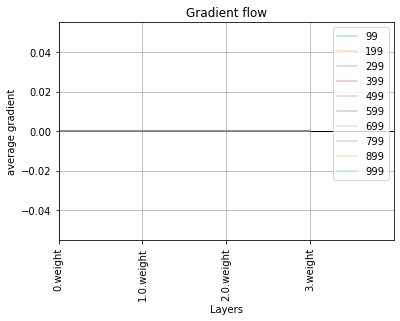

Training complete


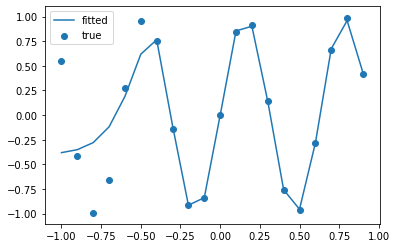

In [38]:
epochs = 1000
model, loss_train_his = training(model, X_train_aug, y_train, lr=0.001, epochs=epochs, visual_debug=True)


model.eval()
y_pred = model(X_train_aug)

X_train_np = X_train.detach().numpy()
y_train_np = y_train.detach().numpy().reshape(-1)
y_pred_np = y_pred.detach().numpy()
# print(y_pred.shape)

plt.scatter(X_train_np, y_train_np, label="true")
plt.plot(X_train_np, y_pred_np, label="fitted")

plt.legend()
plt.show()




## (e) Xavier initialization - theory

Please check the assignment document and derive the formula of Xavier initialization. We will use it in the next part.

## (f) Xavier initialization - practice

Please implement Xavier initialization in the following codes. **You can only use NumPy**, although our codes will convert your results into PyTorch tensors later.

In [40]:
#  Xavier for normal distribution
def init_xavier_normal(w):
    assert (type(w) == np.ndarray), TypeError
    assert len(w.shape) == 2, ValueError("W should be a matrix")
    result = w
    ###
    ### TODO: your codes here
    sigma = ...
    result = ...
    ###
    return(result)

#  Xavier for normal distribution
def init_xavier_uniform(w):
    assert (type(w) == np.ndarray), TypeError
    assert len(w.shape) == 2, ValueError("W should be a matrix")
    result = w
    ###
    ### TODO: your codes here
    d = ...
    result = ...
    ###
    return(result)


## (h) Kaiming initialization - theory

Please check the assignment document and derive the formula of Kaiming initialization. We will use it in the next part.

## (i) Kaiming initialization - practice

Please implement Kaiming initialization in the following codes. **You can only use NumPy**, although our codes will convert your results into PyTorch tensors later.

In [42]:
#  Kaiming for normal distribution
def init_kaiming_normal(w):
    assert (type(w) == np.ndarray), TypeError
    assert len(w.shape) == 2, ValueError("W should be a matrix")
    result = w
    ###
    ### TODO: your codes here
    sigma = ...
    result = ...
    ###
    return(result)


#  Kaiming for normal distribution
def init_kaiming_uniform(w):
    assert (type(w) == np.ndarray), TypeError
    assert len(w.shape) == 2, ValueError("W should be a matrix")
    result = w
    ###
    ### TODO: your codes here
    d = ...
    result = ...
    ###
    return(result)

## (j) Put them all together

99 loss =  0.4739023745059967
Training complete
99 loss =  0.49624648690223694
Training complete
99 loss =  0.5523401498794556
Training complete
99 loss =  0.5514352917671204
Training complete


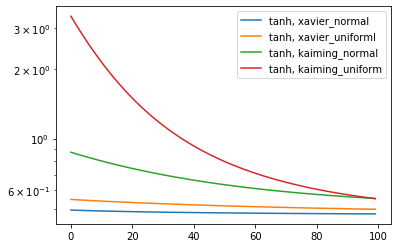

In [71]:
epochs = 100
log_interval = epochs
optimizer = "sgd"

### config

model = create_mlp(L=4, N=16, n_0=2, n_L=1, activation="tanh")
for m in model.modules():
    init_weights(m, method="xavier_normal")

model, loss_train_his = training(model, X_train_aug, y_train, lr=0.001, optimizer=optimizer, epochs=epochs, log_interval=log_interval)

plt.plot(np.arange(epochs), loss_train_his, label="tanh, xavier_normal")


### config

model = create_mlp(L=4, N=16, n_0=2, n_L=1, activation="tanh")
for m in model.modules():
    init_weights(m, method="xavier_uniform")

model, loss_train_his = training(model, X_train_aug, y_train, lr=0.001, optimizer=optimizer, epochs=epochs, log_interval=log_interval)

plt.plot(np.arange(epochs), loss_train_his, label="tanh, xavier_uniforml")


### config

model = create_mlp(L=4, N=16, n_0=2, n_L=1, activation="tanh")
for m in model.modules():
    init_weights(m, method="kaiming_normal")

model, loss_train_his = training(model, X_train_aug, y_train, lr=0.001, optimizer=optimizer, epochs=epochs, log_interval=log_interval)

plt.plot(np.arange(epochs), loss_train_his, label="tanh, kaiming_normal")


### config

model = create_mlp(L=4, N=16, n_0=2, n_L=1, activation="tanh")
for m in model.modules():
    init_weights(m, method="kaiming_uniform")

model, loss_train_his = training(model, X_train_aug, y_train, lr=0.001, optimizer=optimizer, epochs=epochs, log_interval=log_interval)

plt.plot(np.arange(epochs), loss_train_his, label="tanh, kaiming_uniform")

plt.yscale("log")
plt.legend()
plt.show()


999 loss =  0.45987433195114136
Training complete
999 loss =  0.4479753375053406
Training complete
999 loss =  0.4555261731147766
Training complete
999 loss =  0.41172266006469727
Training complete


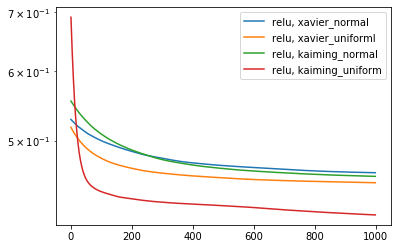

In [69]:
epochs = 1000
log_interval = epochs
optimizer = "sgd"
### config

model = create_mlp(L=4, N=32, n_0=2, n_L=1, activation="relu")
for m in model.modules():
    init_weights(m, method="xavier_normal")

model, loss_train_his = training(model, X_train_aug, y_train, lr=0.001, optimizer=optimizer, epochs=epochs, log_interval=log_interval)

plt.plot(np.arange(epochs), loss_train_his, label="relu, xavier_normal")


### config

model = create_mlp(L=4, N=32, n_0=2, n_L=1, activation="relu")
for m in model.modules():
    init_weights(m, method="xavier_uniform")

model, loss_train_his = training(model, X_train_aug, y_train, lr=0.001, optimizer=optimizer, epochs=epochs, log_interval=log_interval)

plt.plot(np.arange(epochs), loss_train_his, label="relu, xavier_uniforml")


### config

model = create_mlp(L=4, N=32, n_0=2, n_L=1, activation="relu")
for m in model.modules():
    init_weights(m, method="kaiming_normal")

model, loss_train_his = training(model, X_train_aug, y_train, lr=0.001, optimizer=optimizer, epochs=epochs, log_interval=log_interval)

plt.plot(np.arange(epochs), loss_train_his, label="relu, kaiming_normal")


### config

model = create_mlp(L=4, N=32, n_0=2, n_L=1, activation="relu")
for m in model.modules():
    init_weights(m, method="kaiming_uniform")

model, loss_train_his = training(model, X_train_aug, y_train, lr=0.001, optimizer=optimizer, epochs=epochs, log_interval=log_interval)

plt.plot(np.arange(epochs), loss_train_his, label="relu, kaiming_uniform")

plt.yscale("log")
plt.legend()
plt.show()
